# GAN's From Scratch 

by Kris Smith

# Problem Statement

***This notebook is working towards generating images in the style of a famous artist painter [Claude Monet](https://en.wikipedia.org/wiki/Claude_Monet). This problem is presented as a competition on the Kaggle platform for the sake of learning. We will explore in particular one common approach to this task in the form of [Generative Adversarial Networks(GANs)](https://en.wikipedia.org/wiki/Generative_adversarial_network).***

In [1]:
!pip install albumentations
from kaggle_datasets import KaggleDatasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile

import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
AUTOTUNE = tf.data.experimental.AUTOTUNE

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Overview

### Dataset Description
<i>The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.<i>

<i>We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

<i>The monet directories contain Monet paintings. Use these images to train your model.

<i>The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

<i>Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

<i>Check out the CycleGAN dataset to experiment with the artistic style of other artists.</i>

    
### Files
* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

### Submission format
* Your kernel's output must be called images.zip and contain 7,000-10,000 images sized 256x256.
    
    
### Evaluation
    
MiFID
    
Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

The smaller MiFID is, the better your generated images are.

What is FID?
Originally published here (github), FID, along with Inception Score (IS), are both commonly used in recent publications as the standard for evaluation methods of GANs.

In FID, we use the Inception network to extract features from an intermediate layer. Then we model the data distribution for these features using a multivariate Gaussian distribution with mean µ and covariance Σ. The FID between the real images 𝑟
 and generated images 𝑔
 is computed as:
$$
FID = ||\mu_{r} - \mu_{g}||^{2} + Tr(\Sigma_{r} + \Sigma_{g} - 2(\Sigma_{r}\Sigma_{g})^{1/2})
$$

    
    where 𝑇𝑟 sums up all the diagonal elements. FID is calculated by computing the Fréchet distance between two Gaussians fitted to feature representations of the Inception network.

What is MiFID (Memorization-informed FID)?
In addition to FID, Kaggle takes training sample memorization into account.

The memorization distance is defined as the minimum cosine distance of all training samples in the feature space, averaged across all user generated image samples. This distance is thresholded, and it's assigned to 1.0 if the distance exceeds a pre-defined epsilon.

In mathematical form:
    
$$
d_{ij} = 1 - \cos(f_{gi}, f_{rj}) = 1 - \frac{f_{gi} \cdot f_{rj}}{||f_{gi}|| ||f_{rj}||}
$$
    
where 𝑓𝑔
 and 𝑓𝑟
 represent the generated/real images in feature space (defined in pre-trained networks); and 𝑓𝑔𝑖
 and 𝑓𝑟𝑗
 represent the 𝑖𝑡ℎ
 and 𝑗𝑡ℎ
 vectors of 𝑓𝑔
 and 𝑓𝑟
, respectively.

$$
d = \frac{1}{N} \sum_{i} \min_{j} d_{ij}
$$
    
defines the minimum distance of a certain generated image (𝑖
) across all real images ((𝑗
), then averaged across all the generated images.

enter image description here
defines the threshold of the weight only applies when the (𝑑
) is below a certain empirically determined threshold.

Finally, this memorization term is applied to the FID:
    
$$
MiFID = FID * \frac{1}{d_thr}
$$
    
**Kaggle's workflow calculating MiFID for public and private scores**
    
Kaggle calculates public MiFID scores with the pre-train neural network Inception, and the public images used for evaluation are the rest of the TFDS Monet paintings. ***Note that as a Getting Started competition there is no private leaderboard.***

    
### Submission File
    
You are going to generate 7,000-10,000 Monet-style images that are in jpg format. Their sizes should be 256x256x3 (RGB). Then you need to zip those images and your output from your Kernel should only have ONE output file named images.zip.

Please note that Kaggle Kernels has a number of output files capped at 500. We highly encourage you to either directly write to a zip file as you generate images, or create a folder at ../tmp as your temporary directory.


---

# Data

## EDA

In [2]:
BASE_PATH = "../input/gan-getting-started/"
MONET_PATH = os.path.join(BASE_PATH, "monet_jpg")
PHOTO_PATH = os.path.join(BASE_PATH, "photo_jpg")

***Image statistics. The following function was provided by the following notebook: https://www.kaggle.com/code/ihelon/monet-visualization-and-augmentation. This function displays the number of images in the monet and photo folders along with their attributes.***

In [3]:
def print_folder_statistics(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        
    for size, count in d_image_sizes.items():
        print(f"shape: {size}\tcount: {count}")


print(f"Monet images:")
print_folder_statistics(MONET_PATH)
print("-" * 10)
print(f"Photo images:")
print_folder_statistics(PHOTO_PATH)
print("-" * 10)

Monet images:
shape: (256, 256, 3)	count: 300
----------
Photo images:
shape: (256, 256, 3)	count: 7038
----------


***We will focus mainly on the monet images for now. We can see that we are working with 300 of them and each image is 256x256 pixels with 3 channels of color(RGB).***

### Load Data

In [4]:
dataset = keras.utils.image_dataset_from_directory(
    MONET_PATH, 
    label_mode=None, 
    image_size=(256, 256), 
    batch_size=8
)
dataset = dataset.map(lambda x: x / 255.0)

Found 300 files belonging to 1 classes.


### Inspecting Images

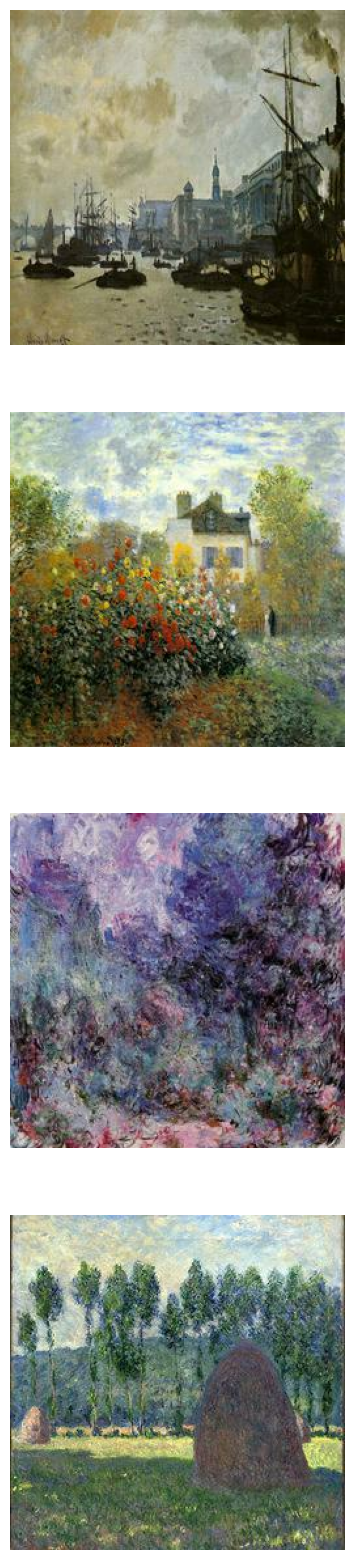

In [5]:
## Choose the number of images to display
n = 4

## Create a temporary dataset to stop iteration after the first batch
dataset_temp = iter(dataset)

## Fetch the first batch
x = next(dataset_temp)

## Make sure the data is in the correct format
if isinstance(x, tuple):
    x = x[0]  

fig, axes = plt.subplots(n, 1, figsize=(20, 20))

for i in range(n):
    img = x[i].numpy()
    img = (img * 255).astype("int32")
    axes[i].axis("off")
    axes[i].imshow(img)

plt.show()

### Feature Engineering

Since we only have 300 images to train on this is not very many for a deep learning model to make use of. There are techniques we can apply to create more training data such as augmentation techniques. Cropping, jittering, rotating, flipping, and normalizing are techniques we can use to apply to the data we have to create new images out of the same data. 

I have used some methods mentioned above which someone had published in this notebook here: https://www.kaggle.com/code/dimitreoliveira/improving-cyclegan-monet-paintings.

In [6]:
IMAGE_SIZE = [256, 256]

def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

def decode_image(image):
    #image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.reshape(image, [256, 256, 3])
    image = tf.image.decode_jpeg(image, channels=3)
    #image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
    return cropped_image

def random_jitter(image):
    # resizing to 286 x 286 x 3 
    image = tf.image.resize(image, [int(256*1.3), int(256*1.3)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
    # random mirroring
    return image

def flip(image):
    return tf.image.flip_left_right(image)

def preprocess_image_train(image, label=None):
    image = random_jitter(image)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=False, ordered=False, repeats=200):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.concatenate(dataset.map(flip, num_parallel_calls=AUTOTUNE).shuffle(100000))
    dataset = dataset.concatenate(dataset.map(random_jitter, num_parallel_calls=AUTOTUNE).shuffle(100000, reshuffle_each_iteration=True).repeat(repeats))
    dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE).shuffle(100000)
    return dataset


dataset = load_dataset(tf.io.gfile.glob(str(KaggleDatasets().get_gcs_path() + '/monet_tfrec/*.tfrec')),
                        labeled=True, 
                        repeats=20).batch(20, drop_remainder=True)
dataset

<_BatchDataset element_spec=TensorSpec(shape=(20, 256, 256, 3), dtype=tf.float32, name=None)>

# Model

After trying a traditional vanilla GAN, and an AutoEncoder and not having much luck with either, I implemented a BiGAN and had some results finally. A BiGAN has a generator and discriminator just like a traditional GAN but you also train an Encoder along side with them. This allows the model to learn how to encode images in order to assist the generator.

## Create the discriminator

It maps a 256x256 image to a binary classification score.

I added Gaussian noise to the input images because the generator was producing the same output for every prediction at inference time. This is know as `mode collapse` and I dealt with it using the noise adding technique along with dropout layers in the discriminator.

After training with sigmoid activation function in the final layer I switched to Tanh which normalizes the outputs to the range of [-1, 1] as opposed to sigmoid which is [0, 1]. This seems to allow the model to learn the RGB scheme better and I think sigmoid would probably work better with black and white images.

In [7]:
## Function to add Gaussian noise to the inputs
def add_noise(layer):
    noise = keras.layers.GaussianNoise(0.2)
    return noise(layer)

In [8]:
latent_dim = 512
input_img = layers.Input(shape=(256, 256, 3))
input_img = add_noise(input_img) ## Add noise

input_z = layers.Input(shape=(latent_dim,))

# image processing
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(input_img)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)

# latent vector processing
y = layers.Dense(512)(input_z)
y = layers.LeakyReLU(alpha=0.2)(y)
y = layers.Dropout(0.3)(y)

# combining the outputs
combined = layers.Concatenate()([x, y])
output = layers.Dense(1, activation="sigmoid")(combined)

discriminator = keras.Model([input_img, input_z], output, name="discriminator")
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 12  6272        ['input_3[0][0]']                
                                8)                                                                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 12  0           ['conv2d[1][0]']                 
                                8)                                                    

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [9]:
latent_dim = 512

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 512),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32768)             16809984  
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 512)      4194816   
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      2097408   
 ranspose)                                                       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 256)       0 

## Create the Encoder

BiGAN model requires an encoder be trained along side the generator.

In [10]:
encoder = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(latent_dim),
    ],
    name="encoder",
)

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 128)     6272      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 256)       524544    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64, 64, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       2097664   
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 512)       0         
                                                                 
 flatten_1 (Flatten)         (None, 524288)            0   

## Create the BiGAN Class

Just like the traditional GAN with the BiGAN the discriminator does not get weights updated with gradient descent like the generator does in training. The encoder also gets updated weights throughout the process.

The class below contains logic to initialize and compile the model as well as train the BiGAN. 

For each batch, training steps include:
* Sample random points in the latent space from embedding model
* Decode them into fake images
* Encode the real images into latent space vectors
* Combine the generated images with the real images
* Combine the encoded latent vectors from the real images with the random latent vectors
* Assemble labels discriminating real from fake image
* Add random noise to the labels
* Train the discriminator
* Sample random points in latent space again
* Assemble labels which are all real
* Train the Generator
* Update weights of generator
* Train the encoder
* Update weights of the encoder

In [11]:
class BiGAN(keras.Model):
    def __init__(self, discriminator, generator, encoder, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.encoder = encoder
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, e_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.e_optimizer = e_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.e_loss_metric = keras.metrics.Mean(name="e_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric, self.e_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Encode real images to latent vectors
        encoded_latent_vectors = self.encoder(real_images)

        # Combine them with real images
        fake_and_real_images = tf.concat([generated_images, real_images], axis=0)
        # Combine them with latent vectors
        encoded_and_random_latent_vectors = tf.concat([encoded_latent_vectors, random_latent_vectors], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([fake_and_real_images, encoded_and_random_latent_vectors])
            d_loss = self.loss_fn(labels, predictions)
#         grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
#         self.d_optimizer.apply_gradients(
#             zip(grads, self.discriminator.trainable_weights)
#         )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator(random_latent_vectors), random_latent_vectors])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Train the encoder (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator([real_images, self.encoder(real_images)])
            e_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(e_loss, self.encoder.trainable_weights)
        self.e_optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        self.e_loss_metric.update_state(e_loss)
        
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "e_loss": self.e_loss_metric.result(),
        }

In [12]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=512):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.test_data = None

    def set_test_data(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs=None):
        # Check if test_data is set
        if self.test_data is not None:
            # Retrieve a batch of data from the dataset
            real_images = next(iter(self.test_data.take(self.num_img)))
            
            # Encode the real images to obtain the latent vectors
            encoded_latent_vectors = self.model.encoder(real_images)
            
            # Generate images from the encoded latent vectors
            generated_images = self.model.generator(encoded_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(self.num_img):
                img = keras.utils.array_to_img(generated_images[i])
                img.save("generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 5  

gan = BiGAN(discriminator=discriminator, generator=generator, encoder=encoder, latent_dim=latent_dim)
gan.compile(
    e_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, 
    epochs=epochs, 
    callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/5
    397/Unknown - 489s 376ms/step - d_loss: 99.0957 - g_loss: 0.1923 - e_loss: 0.0034

In [ ]:
# plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.plot(history.history['e_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['gen_loss', 'enc_loss'], loc='upper left')
plt.show()

In [ ]:
PHOTO_FILENAMES = tf.io.gfile.glob(str(KaggleDatasets().get_gcs_path() + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset


photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    # Encode the input image
    encoded_img = gan.encoder(img)

    # Generate the prediction using the generator
    prediction = gan.generator(encoded_img)[0].numpy()

    # Post-process the images
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = img[0].numpy().astype('float32')
    img = (img * 127.5 + 127.5).astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
import PIL
! mkdir ../images

# Inference

Generate Monet like images from the photos provided in the photo dataset.

In [ ]:
i = 1
for img in photo_ds:
    if i % 350 == 0:
        print(f"{round(i/7038*100)}% Complete")

    # Encode the input image
    encoded_img = gan.encoder(img)
    
    # Generate the prediction using the generator
    prediction = gan.generator(encoded_img)[0].numpy()
    
    # Post-process the images
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    
    # Convert numpy array to image and save it
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

In [ ]:
# Save model weights
gan.save_weights('bigan_weights')
gan.generator.save_weights('bigan_generator_weights')
gan.discriminator.save_weights('bigan_discriminator_weights')
gan.encoder.save_weights('bigan_encoder_weights')

# Load model weights
# gan.load_weights('bigan_weights')
# gan.generator.load_weights('bigan_generator_weights')
# gan.discriminator.load_weights('bigan_discriminator_weights')
# gan.encoder.load_weights('bigan_encoder_weights')